#### * Load required libraries

In [1]:
import sys
import os
import IPython
import math
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
%matplotlib inline

import random
from datetime import datetime
import helpers

from tensorflow.keras import backend as keras_backend
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Dense, SpatialDropout2D, Activation, Conv2D, MaxPooling2D, BatchNormalization, GlobalAveragePooling2D, LeakyReLU
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import ModelCheckpoint 
from tensorflow.keras.regularizers import l2

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import classification_report, precision_recall_fscore_support, confusion_matrix
import warnings
warnings.filterwarnings('ignore')

#### * Setup

In [2]:
# Define general variables

# Set your path to the dataset
us8k_path = os.path.abspath('./UrbanSound8K')
audio_path = os.path.join(us8k_path, 'audio')
metadata_path = os.path.join(us8k_path, 'metadata/UrbanSound8K.csv')
models_path = os.path.abspath('./models')
data_path = os.path.abspath('./data')

# Ensure "channel last" data format on Keras
keras_backend.set_image_data_format('channels_last')

# Define a labels array for future use
labels = [
        'Air Conditioner',
        'Car Horn',
        'Children Playing',
        'Dog bark',
        'Drilling',
        'Engine Idling',
        'Gun Shot',
        'Jackhammer',
        'Siren',
        'Street Music'
    ]

#### * Load MFCC data

Data is an NumPy float32 array of shape (8732, 40, 174), 8732 samples with 40 MFCC coefficients and 174 frames. Each feature was zero-centered and scaled between -1 and 1 during extraction.<br/>
<br/>

In [3]:
# Pre-processed MFCC coefficients
X = np.load("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/extracted_features/X-mfcc.npy")
y = np.load("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/extracted_features/y-mfcc.npy")

# Metadata
metadata = pd.read_csv("C:/Users/VSBAG/Desktop/DSE_Milan/3rd_sem_subject/Machine Learning/Project/Sound_classification/UrbanSound8K/metadata/UrbanSound8K.csv")
metadata.head(5)

,slice_file_name,fsID,start,end,salience,fold,classID,class
0,100032-3-0-0.wav,100032,0.0,0.317551,1,5,3,dog_bark
1,100263-2-0-117.wav,100263,58.5,62.500000,1,5,2,children_playing
2,100263-2-0-121.wav,100263,60.5,64.500000,1,5,2,children_playing
3,100263-2-0-126.wav,100263,63.0,67.000000,1,5,2,children_playing
4,100263-2-0-137.wav,100263,68.5,72.500000,1,5,2,children_playing


In [4]:
def split_data(x,y,train=[],test=[],metadata=metadata):
  x_train,y_train=[],[]
  training_indexes,test_indexes=[],[]
  for ind in train:
    training_indexes=training_indexes+[idx_ for idx_ in metadata.loc[(metadata['fold'] == ind)].index.values]
  x_train=[ x[i] for i in sorted(training_indexes)]
  y_train=[ y[i] for i in sorted(training_indexes)]
  for ind in test:
    test_indexes=test_indexes+[idx_ for idx_ in metadata.loc[(metadata['fold'] == ind)].index.values]
  x_test=[ x[i] for i in sorted(test_indexes)]
  y_test=[ y[i] for i in sorted(test_indexes)]
  return np.array(x_train) , np.array( y_train ) ,np.array(  x_test ) , np.array( y_test) ,training_indexes,test_indexes

### 1. Data preparation: features + metadata

#### 1.1 Train / Test split

Note that we are using the same index order for both the MFCC arrays and the metadata to keep track of the origin of each feature.<br/>
<br/>

In [5]:
indexes = []
total = len(metadata)
indexes = list(range(0, total))

# Randomize indexes
random.shuffle(indexes)

# Divide the indexes into Train and Test
test_split_pct = 20
split_offset = math.floor(test_split_pct * total / 100)

# Split the metadata
test_split_idx = indexes[0:split_offset]
train_split_idx = indexes[split_offset:total]


# Split the features with the same indexes

X_train,y_train,X_test,y_test,train_split_idx,test_split_idx= split_data(X,y,train=[1,2,3,4,6],test=[5,7,8,9,10])

# Also split metadata
test_meta = metadata.iloc[test_split_idx]
train_meta = metadata.iloc[train_split_idx]

# Print status
print("Test split: {} \t\t Train split: {}".format(len(test_meta), len(train_meta)))
print("X test shape: {} \t X train shape: {}".format(X_test.shape, X_train.shape))
print("y test shape: {} \t\t y train shape: {}".format(y_test.shape, y_train.shape))

Test split: 4233 		 Train split: 4499
X test shape: (4233, 40, 174) 	 X train shape: (4499, 40, 174)
y test shape: (4233,) 		 y train shape: (4499,)


# Normalizing the Data
####  One hot encode labels

In [6]:
le = LabelEncoder()
y_test_encoded = to_categorical(le.fit_transform(y_test))
y_train_encoded = to_categorical(le.fit_transform(y_train))

####  Reshape data

In [12]:
# How data should be structured
num_rows = 40
num_columns = 174 
num_channels = 1

# Reshape to fit the network input (channel last)
X_train = X_train.reshape(X_train.shape[0], num_rows, num_columns, num_channels)
X_test = X_test.reshape(X_test.shape[0], num_rows, num_columns, num_channels)

# Total number of labels to predict (equal to the network output nodes)
num_labels = y_train_encoded.shape[1]
# Train Shape
X_train.shape

(4499, 40, 174, 1)

# Check PCA benefits

Text(0, 0.5, 'Variance (%)')

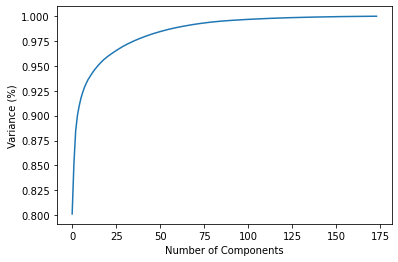

In [13]:
scaler = StandardScaler()
scaler.fit(X_train[:,0, ::,0])
x_train_scaled = scaler.transform(X_train[:,0, ::,0])

pca = PCA().fit(x_train_scaled)

plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('Number of Components')
plt.ylabel('Variance (%)')

As we can see most of the variance is explained using all the features of the MFCC. This is expected since each feature gives information about the wave shape. Finally we can fit our model.

### CNN Model



In [14]:
def create_model(spatial_dropout_rate_1=0, spatial_dropout_rate_2=0, l2_rate=0):

    # Create a secquential object
    model = Sequential()


    # Conv 1
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate), 
                     input_shape=(num_rows, num_columns, num_channels)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=32, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())


    # Max Pooling #1
    model.add(MaxPooling2D(pool_size=(2, 2)))

    model.add(SpatialDropout2D(spatial_dropout_rate_1))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3, 3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())

    model.add(SpatialDropout2D(spatial_dropout_rate_2))
    model.add(Conv2D(filters=64, 
                     kernel_size=(3,3), 
                     kernel_regularizer=l2(l2_rate)))
    model.add(LeakyReLU(alpha=0.1))
    model.add(BatchNormalization())
    
   
    # Reduces each h×w feature map to a single number by taking the average of all h,w values.
    model.add(GlobalAveragePooling2D())


    # Softmax output
    model.add(Dense(num_labels, activation='softmax'))
    
    return model

# Regularization rates
spatial_dropout_rate_1 = 0.07
spatial_dropout_rate_2 = 0.14
l2_rate = 0.0005

model = create_model(spatial_dropout_rate_1, spatial_dropout_rate_2, l2_rate)

####  Setup model optimizer and loss function

Using [ADAM](https://machinelearningmastery.com/adam-optimization-algorithm-for-deep-learning/) with default parameters to start from somewhere, then reduced learning rate to 1e-4 (as loss history was noisy).
Loss function is categorical cross-entropy as we are predicting between 10 classes.


In [15]:
adam = Adam(lr=1e-4, beta_1=0.99, beta_2=0.999)
model.compile(
    loss='categorical_crossentropy', 
    metrics=['accuracy'], 
    optimizer=adam)

# Display model architecture summary 
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 38, 172, 32)       320       
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 38, 172, 32)       0         
_________________________________________________________________
batch_normalization (BatchNo (None, 38, 172, 32)       128       
_________________________________________________________________
spatial_dropout2d (SpatialDr (None, 38, 172, 32)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 36, 170, 32)       9248      
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 36, 170, 32)       0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 36, 170, 32)       1

### Training the model

In [16]:
num_epochs = 250
num_batch_size = 128
model_file = 'simple-train-nb3.hdf5'
model_path = os.path.join(models_path, model_file)


# Save checkpoints
checkpointer = ModelCheckpoint(filepath=model_path, 
                               verbose=1, 
                               save_best_only=True)
start = datetime.now()
history = model.fit(X_train, 
                    y_train_encoded, 
                    batch_size=num_batch_size, 
                    epochs=num_epochs, 
                    validation_split=1/12.,
                    callbacks=[checkpointer], 
                    verbose=1)

duration = datetime.now() - start
print("Training completed in time: ", duration)

Epoch 1/250
33/33 [==============================] - 155s 4s/step - loss: 2.2432 - accuracy: 0.1998 - val_loss: 2.3761 - val_accuracy: 0.0373

Epoch 00001: val_loss improved from inf to 2.37606, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\urban-audio-classifier-master\models\simple-train-nb3.hdf5
Epoch 2/250
33/33 [==============================] - 144s 4s/step - loss: 1.9938 - accuracy: 0.3303 - val_loss: 2.3762 - val_accuracy: 0.0853

Epoch 00002: val_loss did not improve from 2.37606
Epoch 3/250
33/33 [==============================] - 143s 4s/step - loss: 1.8700 - accuracy: 0.3822 - val_loss: 2.3809 - val_accuracy: 0.0853

Epoch 00003: val_loss did not improve from 2.37606
Epoch 4/250
33/33 [==============================] - 141s 4s/step - loss: 1.7785 - accuracy: 0.4047 - val_loss: 2.3921 - val_accuracy: 0.1013

Epoch 00004: val_loss did not improve from 2.37606
Epoch 5/250
33/33 [==============================] - 

33/33 [==============================] - 112s 3s/step - loss: 0.8877 - accuracy: 0.7488 - val_loss: 1.7459 - val_accuracy: 0.5067

Epoch 00067: val_loss did not improve from 1.72261
Epoch 68/250
33/33 [==============================] - 111s 3s/step - loss: 0.8845 - accuracy: 0.7532 - val_loss: 1.7488 - val_accuracy: 0.5120

Epoch 00068: val_loss did not improve from 1.72261
Epoch 69/250
33/33 [==============================] - 111s 3s/step - loss: 0.8818 - accuracy: 0.7524 - val_loss: 1.7280 - val_accuracy: 0.5093

Epoch 00069: val_loss did not improve from 1.72261
Epoch 70/250
33/33 [==============================] - 109s 3s/step - loss: 0.8785 - accuracy: 0.7544 - val_loss: 1.7187 - val_accuracy: 0.5040

Epoch 00070: val_loss improved from 1.72261 to 1.71873, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\urban-audio-classifier-master\models\simple-train-nb3.hdf5
Epoch 71/250
33/33 [==============================] - 113s

33/33 [==============================] - 141s 4s/step - loss: 0.7220 - accuracy: 0.7992 - val_loss: 1.6652 - val_accuracy: 0.5200

Epoch 00103: val_loss improved from 1.67813 to 1.66524, saving model to C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\urban-audio-classifier-master\models\simple-train-nb3.hdf5
Epoch 104/250
33/33 [==============================] - 128s 4s/step - loss: 0.7088 - accuracy: 0.8116 - val_loss: 1.6693 - val_accuracy: 0.5280

Epoch 00104: val_loss did not improve from 1.66524
Epoch 105/250
33/33 [==============================] - 118s 4s/step - loss: 0.6949 - accuracy: 0.8135 - val_loss: 1.6765 - val_accuracy: 0.5253

Epoch 00105: val_loss did not improve from 1.66524
Epoch 106/250
33/33 [==============================] - 115s 3s/step - loss: 0.7125 - accuracy: 0.8026 - val_loss: 1.6834 - val_accuracy: 0.5120

Epoch 00106: val_loss did not improve from 1.66524
Epoch 107/250
33/33 [==============================] - 

33/33 [==============================] - 116s 4s/step - loss: 0.4964 - accuracy: 0.8737 - val_loss: 1.7363 - val_accuracy: 0.5467

Epoch 00182: val_loss did not improve from 1.60352
Epoch 183/250
33/33 [==============================] - 116s 4s/step - loss: 0.4898 - accuracy: 0.8768 - val_loss: 1.6977 - val_accuracy: 0.5467

Epoch 00183: val_loss did not improve from 1.60352
Epoch 184/250
33/33 [==============================] - 115s 3s/step - loss: 0.4992 - accuracy: 0.8729 - val_loss: 1.6499 - val_accuracy: 0.5733

Epoch 00184: val_loss did not improve from 1.60352
Epoch 185/250
33/33 [==============================] - 117s 4s/step - loss: 0.4955 - accuracy: 0.8715 - val_loss: 1.6354 - val_accuracy: 0.5920

Epoch 00185: val_loss did not improve from 1.60352
Epoch 186/250
33/33 [==============================] - 116s 3s/step - loss: 0.4944 - accuracy: 0.8676 - val_loss: 1.6578 - val_accuracy: 0.5813

Epoch 00186: val_loss did not improve from 1.60352
Epoch 187/250
33/33 [=============

33/33 [==============================] - 118s 4s/step - loss: 0.4246 - accuracy: 0.8962 - val_loss: 1.7051 - val_accuracy: 0.5733

Epoch 00223: val_loss did not improve from 1.58667
Epoch 224/250
33/33 [==============================] - 118s 4s/step - loss: 0.4226 - accuracy: 0.8950 - val_loss: 1.6809 - val_accuracy: 0.5813

Epoch 00224: val_loss did not improve from 1.58667
Epoch 225/250
33/33 [==============================] - 116s 3s/step - loss: 0.4214 - accuracy: 0.8911 - val_loss: 1.6890 - val_accuracy: 0.5867

Epoch 00225: val_loss did not improve from 1.58667
Epoch 226/250
33/33 [==============================] - 118s 4s/step - loss: 0.4268 - accuracy: 0.8892 - val_loss: 1.6720 - val_accuracy: 0.5787

Epoch 00226: val_loss did not improve from 1.58667
Epoch 227/250
33/33 [==============================] - 115s 3s/step - loss: 0.4232 - accuracy: 0.8948 - val_loss: 1.6760 - val_accuracy: 0.5947

Epoch 00227: val_loss did not improve from 1.58667
Epoch 228/250
33/33 [=============

### General model evaluation
We first load the checkpoint with the lowest validation loss achieved during training. We then use the Test set to evaluate the model with data that has not been seen by the model nor by me when tuning hyper-parameters.

In [18]:
# Load best saved model
model = load_model(model_path)

helpers.model_evaluation_report(model, X_train, y_train_encoded, X_test, y_test_encoded)

                    LOSS      ACCURACY
--------------------------------------
Training:         0.4721       89.1976
Test:             1.2291       66.0997
Normal diff         61.59 


####  Train vs Test history plot

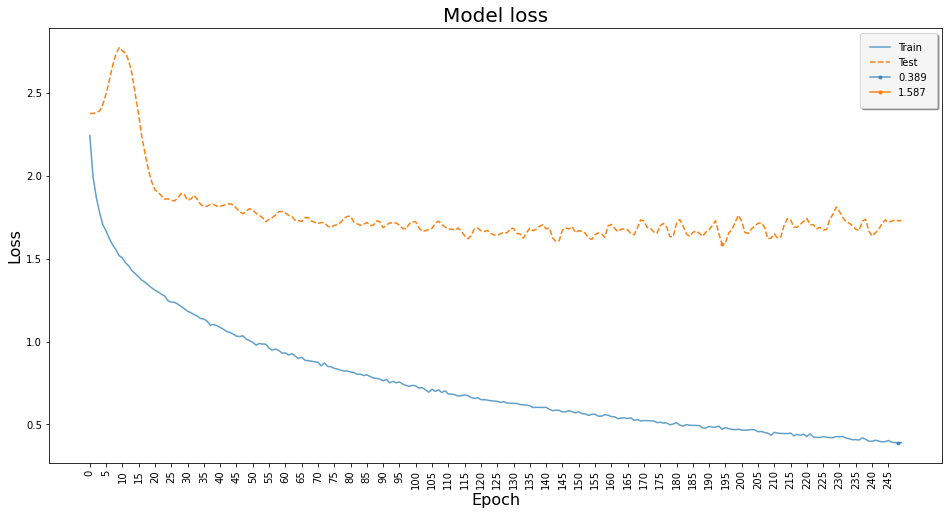

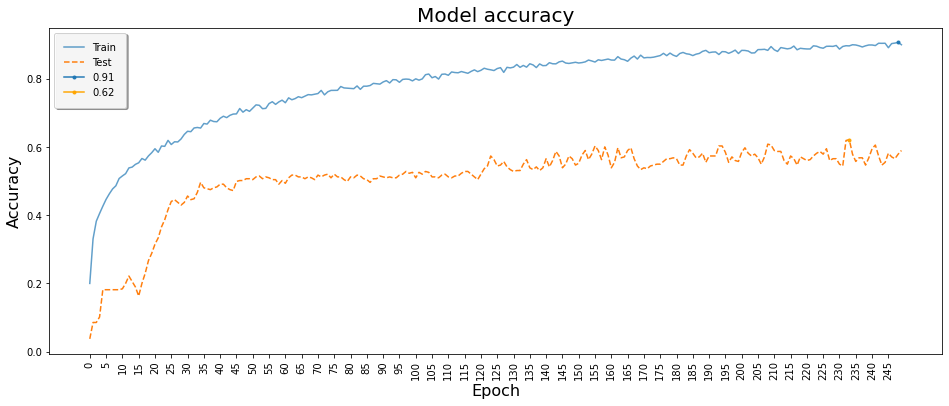

In [19]:
helpers.plot_train_history(history, x_ticks_vertical=True)

###  Model evaluation
Now let's see how the model performs predicting the different classes using data from the test set, data that has not been used to train the model.<br/>
<br/>

#### * Register model output

In [20]:
# Predict probabilities for test set
y_probs = model.predict(X_test, verbose=0)

# Get predicted labels
yhat_probs = np.argmax(y_probs, axis=1)
y_trues = np.argmax(y_test_encoded, axis=1)

# Add "pred" column
test_meta['pred'] = yhat_probs

<ipython-input-20-0adc5dd7a3c7>:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_meta['pred'] = yhat_probs


#### Confussion matrix

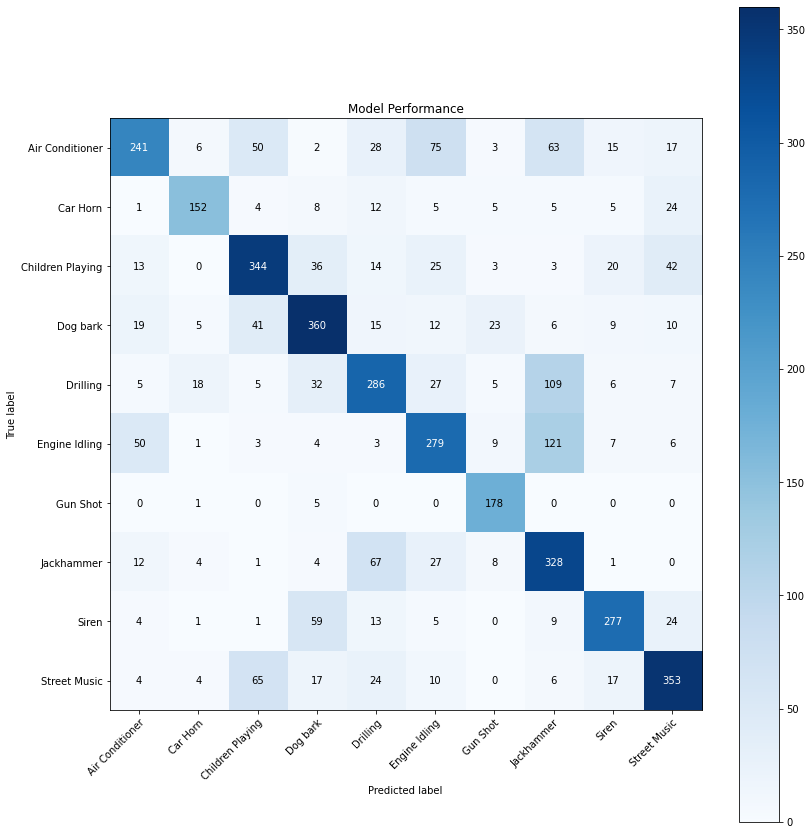

In [21]:
# Sets decimal precision (for printing output only)
np.set_printoptions(precision=2)

# Compute confusion matrix data
cm = confusion_matrix(y_trues, yhat_probs)

helpers.plot_confusion_matrix(cm,
                          labels, 
                          normalized=False, 
                          title="Model Performance", 
                          cmap=plt.cm.Blues,
                          size=(12,12))

#### Accuracy table

In [22]:
# Find per-class accuracy from the confusion matrix data
accuracies = helpers.acc_per_class(cm)

pd.DataFrame({
    'CLASS': labels,
    'ACCURACY': accuracies
}).sort_values(by="ACCURACY", ascending=False)

,CLASS,ACCURACY
6,Gun Shot,96.739130
7,Jackhammer,72.566372
3,Dog bark,72.000000
9,Street Music,70.600000
8,Siren,70.483461
2,Children Playing,68.800000
1,Car Horn,68.778281
5,Engine Idling,57.763975
4,Drilling,57.200000
0,Air Conditioner,48.200000


#### Classification performance: Presicion, Recall and F1 scores



In [23]:
# Build classification report
re = classification_report(y_trues, yhat_probs, labels=[0,1,2,3,4,5,6,7,8,9], target_names=labels)

print(re)

                  precision    recall  f1-score   support

 Air Conditioner       0.69      0.48      0.57       500
        Car Horn       0.79      0.69      0.74       221
Children Playing       0.67      0.69      0.68       500
        Dog bark       0.68      0.72      0.70       500
        Drilling       0.62      0.57      0.59       500
   Engine Idling       0.60      0.58      0.59       483
        Gun Shot       0.76      0.97      0.85       184
      Jackhammer       0.50      0.73      0.60       452
           Siren       0.78      0.70      0.74       393
    Street Music       0.73      0.71      0.72       500

        accuracy                           0.66      4233
       macro avg       0.68      0.68      0.68      4233
    weighted avg       0.67      0.66      0.66      4233



### Exploring the misclassified


#### Street music as Children playing 

In [42]:
# Find the target misclassified ocurrencies
street_as_children = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 2)]

files = []
for idx, row in street_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [43]:
print("Children playing as Street music: {} ocurrencies".format(len(street_as_children)))

# Manully set the file index
index = 12
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Children playing as Street music: 97 ocurrencies

True category: street_music
File: C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\urban-audio-classifier-master\UrbanSound8K\audio/fold7/61789-9-0-12.wav


#### Drilling as Jack Hammer

In [33]:
# Find the target misclassified ocurrencies
drilling_as_jack = test_meta[(test_meta['classID'] == 4) & (test_meta['pred'] == 7)]
files = []
for idx, row in drilling_as_jack.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)


In [35]:
print("Drilling as Jack Hammer: {} ocurrencies".format(len(drilling_as_jack)))

# Manully set the file index
index = 3
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Drilling as Jack Hammer: 72 ocurrencies

True category: drilling
File: C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\urban-audio-classifier-master\UrbanSound8K\audio/fold5/118440-4-3-0.wav


#### Dog Bark as Children Playing

In [37]:
# Drilling as Air Conditioner
dogbar_as_children = test_meta[(test_meta['classID'] == 3) & (test_meta['pred'] == 2)]

files = []
for idx, row in dogbar_as_children.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [38]:
print("Dog Bark as Children Playing: {} ocurrencies".format(len(dogbar_as_children)))
    
# Manully set the file index
index = 8
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Dog Bark as Children Playing: 51 ocurrencies

True category: dog_bark
File: C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\urban-audio-classifier-master\UrbanSound8K\audio/fold5/77233-3-0-7.wav


#### Street Music as Air Conditioner

In [40]:
# Street Music as Air Conditioner
music_as_aircon = test_meta[(test_meta['classID'] == 9) & (test_meta['pred'] == 0)]

files = []
for idx, row in music_as_aircon.iterrows():
    fold_num = str(row['fold'])
    file_name = row['slice_file_name']
    category = row['class']
    file_path = audio_path + '/fold'+ fold_num +'/' + file_name
    files.append(file_path)

In [41]:
print("Street Music as Air Conditioner: {} ocurrencies".format(len(music_as_aircon)))

# Manully set the file index
index = 2
   
# Display results
print("\nTrue category: {}".format(category))
print("File: {}".format(files[index]))

Street Music as Air Conditioner: 29 ocurrencies

True category: street_music
File: C:\Users\VSBAG\Desktop\DSE_Milan\3rd_sem_subject\Machine Learning\Project\Sound_classification\urban-audio-classifier-master\UrbanSound8K\audio/fold5/164344-9-0-40.wav
